# Example Data Prep (M100 Fluke)
> Example of preparing image set for training
> This may involve resizing to a common resolution and size so that the tiling operations will be consistant.
> Each image file is marked up with egg centers identified in the csv file. We process these csv files to make JSON files in the same format as was in the labelme project [labelme](

In [1]:
#hide
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [53]:
from  cellsegment.dataprep_utils import *
from cellsegment.set_directories import *
import pandas
import numpy as np

## Define directories

In [6]:
dirs = Dirs('../testdata_3')
print(dirs)

None
  basepath        :  ../testdata_3        
  crop            :  ../testdata_3/Crop-200 
  cropLabel       :  ../testdata_3/Crop-200/Label 
  cropTest        :  ../testdata_3/Crop-200/Test 
  cropTrain       :  ../testdata_3/Crop-200/Train 
  cropValidTxtFile:  ../testdata_3/Crop-200/valid.txt 
  label           :  ../testdata_3/Fullsize/Label 
  model           :  ../testdata_3/models/ 
  originImages    :  ../testdata_3/Original 
  sizeCsvFile     :  ../testdata_3/file_size.csv 
  test            :  ../testdata_3/Fullsize/Test 
  train           :  ../testdata_3/Fullsize/Train 
  validTxtFile    :  ../testdata_3/Fullsize/valid.txt 



> Change this ....
> Dataset consists of legacy images and micro-i images
> Structure  
> Split into 70% Train, 15% Val, 15% Test  :  taken randomly for the 354 images.  
    - Original (jpg+csv+json)  [354 jpg; 354 csv; 354 json; Total = 1062]  
    - Fullsize    (random split into 70% Train, 15% Val, 15% Test)  
        - Train
            - (354 jpg + 354 json)
        - Label
            - (354 png)
    - Crop-200
        - Error
            - nil
        - Train
            - (443 jpg)
        - Labels
            - (526 png)
        - Test
            - (83 jpg)
        - valid.txt 
            - 73 file names

## get stats on images

In [56]:
from fastai.vision import get_image_files, parallel, partial, PIL, Path, get_files
MicroI_100_Images_path = dirs.originImages

print(MicroI_100_Images_path)

image_files = get_image_files(MicroI_100_Images_path)
json_files = get_files(MicroI_100_Images_path, extensions=['.json'])

for i, fn in enumerate(image_files):
    image_files[i] = fn.name.split('.')[0]
for i, fn in enumerate(json_files):
    json_files[i] = fn.name.split('.')[0]
    
print(f'Number of Micro-I images = {len(image_files)}')

print(f"Number of Micro-I json files = { len(json_files) }")
set1 = set(image_files)
set2 = set(json_files)

missing = list(sorted(set1 - set2))
added = list(sorted(set2 - set1))
print('missing:', len(missing), missing)
print('added:', len(added), added)




../testdata_3/Original
Number of Micro-I images = 144
Number of Micro-I json files = 143
missing: 1 ['236567 - 19']
added: 0 []


In [62]:
print("Show original image sizes")

height = 800
fnames = sorted(get_image_files(dirs.originImages))

list_filedata = [None] * len(fnames)
for i,fn in enumerate(fnames):
    img = PIL.Image.open(fn)
    img_w, img_h = img.size
    scale = float(height) / img_h
    list_filedata[i] = {'Name':fn.name, 'Width':img_w, 'Height':img_h, 'Scale':scale}

df = pandas.DataFrame(list_filedata)
df = df[['Name', 'Width', 'Height']]
# print(df)

savefn = Path(dirs.sizeCsvFile)
if not savefn.exists():
    print(f'Saving {savefn}')
    df.to_csv(savefn)
else:
    print(f'Filename {savefn} already exists')
print(df.head())
  
print(df.tail())


Show original image sizes
Filename ../testdata_3/file_size.csv already exists
              Name  Width  Height
0   236567 - 1.jpg   1627    1623
1  236567 - 10.jpg   1624    1611
2  236567 - 11.jpg   1634    1694
3  236567 - 12.jpg   1611    1659
4  236567 - 13.jpg   1598    1662
                Name  Width  Height
138  236568 - 95.jpg    852     836
139  236568 - 96.jpg    814     813
140  236568 - 97.jpg    826     786
141  236568 - 98.jpg    797     773
142  236568 - 99.jpg    811     777


## Optional - Convert directory of CSV files to JSON files

In [52]:
csv_to_json_dir(dirs.originImages, dirs.originImages, number_files='all')     

Converting an entire directory of Techion CSV files to JSON files
Number of csv & jpg files to convert 143 144
src_path ../testdata_3/Original
dest_path ../testdata_3/Original
::::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
:::::::::::::::::::::::::::::::::::::::::::

## Resize jpg & json files 

In [64]:
resize_dir(dirs.sizeCsvFile, dirs.originImages, dirs.train, number_files='all', height=800)

Number of image files: 143, Number to resize: all
::::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
:::::::::::::::::::::::::::::::::::::::::::

In [63]:
resize_json_dir(dirs.sizeCsvFile, dirs.originImages, dirs.train, number_files='all', height=800)

Number of JSON files: 143, Number to resize: all
::::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
:::::::::::::::::::::::::::::::::::::::::::
143  json files processed


143

### Create label png images based on Json files and store in dest directory")

In [65]:
create_labels_dir(dirs.train, dirs.label, number_files='all')

Create label png images based on Json files and store in dest directory
Number of json files to process 143
::::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
:::::::::::::::::::::::::::::::::::::::::::Number of labels files created 143


## Split into Train, Val and Test

In [66]:
file_csv = dirs.basepath+'/file_data.csv'
fnames = sorted(get_image_files(dirs.train))
fnames = [fn.name for fn in fnames]
df = pandas.DataFrame(fnames)
df.columns = ['Name']
df.to_csv(file_csv, index=True)

shuffle_csv(file_csv,random_state=23)

In [67]:
print('\n Split into train valid and test directories')
split_filenames(file_csv, num_train=0.5, num_val=0.25)


 Split into train valid and test directories


In [68]:
misslist, croplist= crop_img_dir(file_csv, dirs.train, dirs.train, dirs.crop, 
                                              number_files='all', DEBUG=False)
print(f'Num Missed: {len(misslist)}, Num Cropped: {len(croplist)}')

144 files to process in ../testdata_3/Fullsize/Train
:::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
::::::::::::::::::::::::::::::::::::::::::::
Missed 1 and  Cropped 213 files in ../testdata_3/Crop-200
Num Missed: 1, Num Cropped: 213


In [78]:
crop_df = pandas.DataFrame(croplist)
crop_df = crop_df[['Name','Label', 'Op']]
crop_df.to_csv(dirs.crop+'/crop_df.csv')
crop_df.tail()

,Name,Label,Op
208,236568 - 108-0.jpg,11,Test
209,236568 - 51-0.jpg,11,Test
210,236568 - 100-0.jpg,11,Test
211,236568 - 109-0.jpg,11,Test
212,236568 - 44-0.jpg,11,Test


In [79]:
valid_df = crop_df[crop_df.Op=='Valid'].loc[:,'Name']
valid_df.to_csv(dirs.crop+'/valid.txt', index=False, header=True)
valid_df.head(10)

108     236567 - 17-0.jpg
109     236567 - 17-1.jpg
110     236568 - 42-0.jpg
111     236568 - 61-0.jpg
112     236568 - 30-0.jpg
113     236568 - 30-1.jpg
114     236568 - 55-0.jpg
115     236568 - 65-0.jpg
116    236568 - 110-0.jpg
117     236568 - 33-0.jpg
Name: Name, dtype: object

In [80]:
labmisslist, labcroplist = crop_img_dir(file_csv, dirs.train, dirs.label, dirs.crop, number_files='all')
print(f'Num Missed: {len(labmisslist)}, Num Cropped: {len(labcroplist)}')

144 files to process in ../testdata_3/Fullsize/Label
:::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
::::::::::::::::::::::::::::::::::::::::::::
Missed 1 and  Cropped 213 files in ../testdata_3/Crop-200
Num Missed: 1, Num Cropped: 213


## Save test_data.csv

In [72]:
crop_df = pandas.read_csv(dirs.crop+'/crop_df.csv', index_col=0)
crop_df.loc[crop_df.Label == 40,'Label'] = 'Fluke-Rumen'
crop_df.loc[crop_df.Label == 11,'Label'] = 'Fluke-Liver'
crop_df.to_csv(dirs.crop+'/crop_df.csv')
crop_df.tail()

,Name,Label,Op
208,236568 - 108-0.jpg,Fluke-Liver,Test
209,236568 - 51-0.jpg,Fluke-Liver,Test
210,236568 - 100-0.jpg,Fluke-Liver,Test
211,236568 - 109-0.jpg,Fluke-Liver,Test
212,236568 - 44-0.jpg,Fluke-Liver,Test


In [81]:
test_df = crop_df[crop_df.Op == 'Test'] 
test_df.to_csv(dirs.crop+'/test_df.csv', index=False)
test_df.tail()

,Name,Label,Op
208,236568 - 108-0.jpg,11,Test
209,236568 - 51-0.jpg,11,Test
210,236568 - 100-0.jpg,11,Test
211,236568 - 109-0.jpg,11,Test
212,236568 - 44-0.jpg,11,Test


## Save label files without color pallet info
> otherwise databunch segmentation does not work

In [74]:
fnames =  get_image_files(Path(dirs.crop)/'Label')
# fnames = fnames[:3]
for fn in fnames:
    img = np.asarray(PIL.Image.open(fn))
    PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)



## Test Create DataBunch

In [75]:
# create data set
from fastai.vision import *
from fastai.utils.mem import *
path_img = dirs.cropTrain
path_lbl = dirs.cropLabel

codes = np.array(['background', '1', '2', '3']);codes

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_label_fn, classes=codes, convert_mode='RGB'))

tfms = get_transforms(flip_vert=True, max_rotate=None, max_zoom=1., max_warp=None)

bs = 8
data = (src.transform(tfms, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

## Show example images

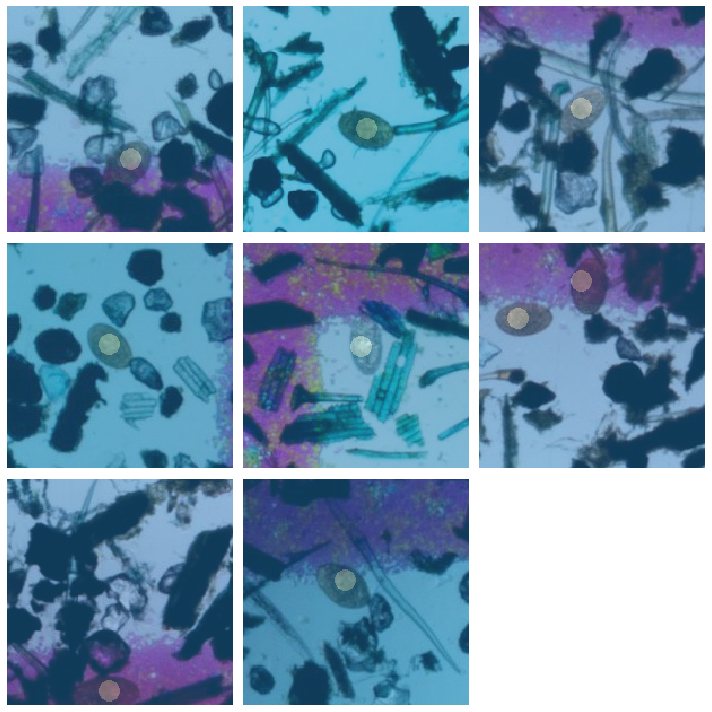

In [76]:
data.show_batch(4, ds_type=DatasetType.Train, figsize=(10,10))

In [41]:
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]

wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()



## run fastai learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


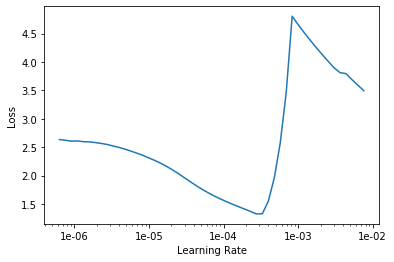

In [42]:
if torch.cuda.is_available():
    learn.lr_find()
    learn.recorder.plot()


## All done!